# AMLD 2021

> ##### Machine Learning in Science: Encoding physical constraints and good development practices


## Example 03 - Physics "embedding" by post-prediction algorithmic corrections

In this notebook, we demonstrating a method for ensuring physical consistency of the predictions without touching the loss function.

### Workshop Organizers

* Dr. Maria Han Veiga (University of Michigan, USA)

* Dr. Miles Timpe (University of Zurich, Switzerland)

### Import libraries

In [1]:
from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.metrics import r2_score


# Global seed value
seed = 42

# Set random seeds
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


# Versions can also influence reproducibility
from sys import version
print(f"Python version: {version}")

Python version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


### Load test data and scalers

In [2]:
targets = ['lr_mass', 'slr_mass', 'debris_mass']

features = ['mtotal', 'gamma', 'b_inf', 'v_inf',
            'targ_core_fraction', 'targ_omega', 'targ_theta', 'targ_phi',
            'proj_core_fraction', 'proj_omega', 'proj_theta', 'proj_phi',
            ] + targets


x_test = pd.read_csv('../datasets/test.csv', usecols=features)

x_test = x_test[x_test['lr_mass'] > 0]


#y_test  = x_test.pop(target)


# Load scalers and scale targets
scalers = {}
data = {}

for name in targets:
    
    scalers[f"y_{name}"] = load(f"../models/y_scaler_{name}.joblib")
    
    y_test = x_test.pop(name)
    
    scaled_y_test = scalers[f"y_{name}"].transform(y_test.values.reshape(-1, 1))
    
    scaled_y_test = pd.Series(data=np.squeeze(scaled_y_test), name=name)
    
    data[name] = {'y_test': y_test, 'scaled_y_test': scaled_y_test}
    
    del y_test
    

# Scale features
x_scaler = load(f"../models/x_scaler.joblib")

scaled_x_test = pd.DataFrame(x_scaler.transform(x_test), columns=x_test.columns)

### Load pre-trained models

Since we already trained our models in the previous notebooks, we will simply load them from the saved joblib files. 

In [3]:
models = {}

predictions = {}

for name in targets:
    
    # Load saved model
    models[name] = load(f"../models/regressor_mlp_{name}.joblib")
    
    # Load true values
    y_test = data[name]['y_test']
    
    predictions[f"{name.split('_')[0]}_true"] = y_test
    
    # Predict values
    scaled_y_pred = models[name].predict(scaled_x_test)
    
    y_pred = pd.Series(scalers[f"y_{name}"].inverse_transform(scaled_y_pred), name='y_pred').values
    
    # Calculate the quality of the predictions with the r2 score
    r2 = r2_score(y_test, y_pred)

    
    predictions[name] = y_pred
    
    del scaled_y_pred, y_pred
    
    print(f"{name}: r2_score = {r2:.4f}")
    
    
# Compile the predictions in a Pandas DataFrame
data = pd.DataFrame(data=predictions)

data['m_tot'] = x_test['mtotal']

lr_mass: r2_score = 0.9866
slr_mass: r2_score = 0.9514
debris_mass: r2_score = 0.9863


### Plot: mass residual histogram

In order to get an idea of how bad the uncoupled models are at conserving mass, we plot a histogram of the mass residuals. The residuals are simply the difference in predicted final total mass vs the true initial total mass. The range of total mass is large, so we plot the normalized mass residuals to account for this.

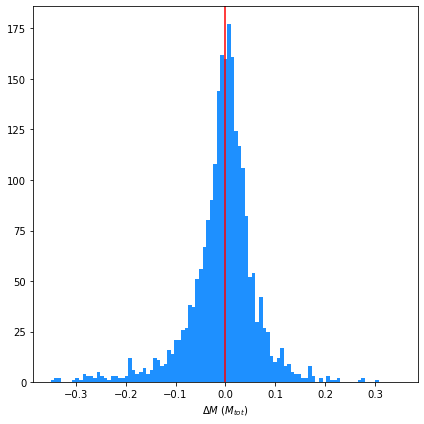

In [4]:
def mass_residual(row):
    # Calculate the normalized mass residual
    
    dM = row['m_tot'] - row['lr_mass'] - row['slr_mass'] - row['debris_mass']
    
    return dM / row['m_tot']


data['residual'] = data.apply(mass_residual, axis=1)


# Histogram
fig, ax = plt.subplots(1, 1, figsize=(6,6))

ax.set_xlabel(r'$\Delta M$ $(M_{tot})$')

ax.hist(data.residual, bins=np.linspace(-0.35, 0.35, num=100),
        color='dodgerblue')

ax.axvline(x=0, color='red', alpha=1)

plt.tight_layout()

### Physical constraints: mass conservation

From the r2 scores reported above, it's clear that the predictions of the SLR (second largest remnant) mass are significantly worse than the predictions for the other targets. 

In [5]:
def best_two(row):    
    # We use the most accurate two regressors and the third is replaced by the residual.
    
    # Ensure no negative masses
    m_lr = np.max([0.0, row['lr_mass']])
    m_slr = np.max([0.0, row['slr_mass']])
    m_deb = np.max([0.0, row['debris_mass']])
    
    
    if m_lr >= row['m_tot']:
        
        return row['m_tot'], 0.0, 0.0
    
    elif m_lr + m_deb > row['m_tot']:
        
        return m_lr, 0.0, row['m_tot'] - m_lr
    
    else:

        m_slr = row['m_tot'] - m_lr - m_deb

        return m_lr, m_slr, m_deb


data[['lr_pred', 'slr_pred', 'debris_pred']] = data.apply(best_two, axis=1, result_type="expand")

In [6]:
def new_residual(row):
    # Calculate the normalized mass residual
    
    dM = row['m_tot'] - row['lr_pred'] - row['slr_pred'] - row['debris_pred']
    
    return dM / row['m_tot']


data['new_residual'] = data.apply(new_residual, axis=1)


print(f"deltaM min = {data.new_residual.min()}")
print(f"deltaM max = {data.new_residual.max()}")

deltaM min = -5.288298019719663e-17
deltaM max = 4.5587384023297355e-17


In [7]:
print(f"{'Mass':>8}{'Unconstrained':>22}{'Constrained':>18}")

for name in targets:
    
    name = name.split('_')[0]
    
    # Load true values
    y_test = data[f"{name}_true"]
    y_pred = data[f"{name}_mass"]
    y_phys = data[f"{name}_pred"]
    
    # Calculate the quality of the predictions with the r2 score
    r2_pred = r2_score(y_test, y_pred)
    r2_phys = r2_score(y_test, y_phys)
    
    
    print(f"{name:>8}{r2_pred:>15.4f}{r2_phys:>20.4f}")

    Mass         Unconstrained       Constrained
      lr         0.9866              0.9870
     slr         0.9514              0.9372
  debris         0.9863              0.9859


### Comments

As we can see from the results above, we have traded a bit of accuracy in return for obeying physics. 

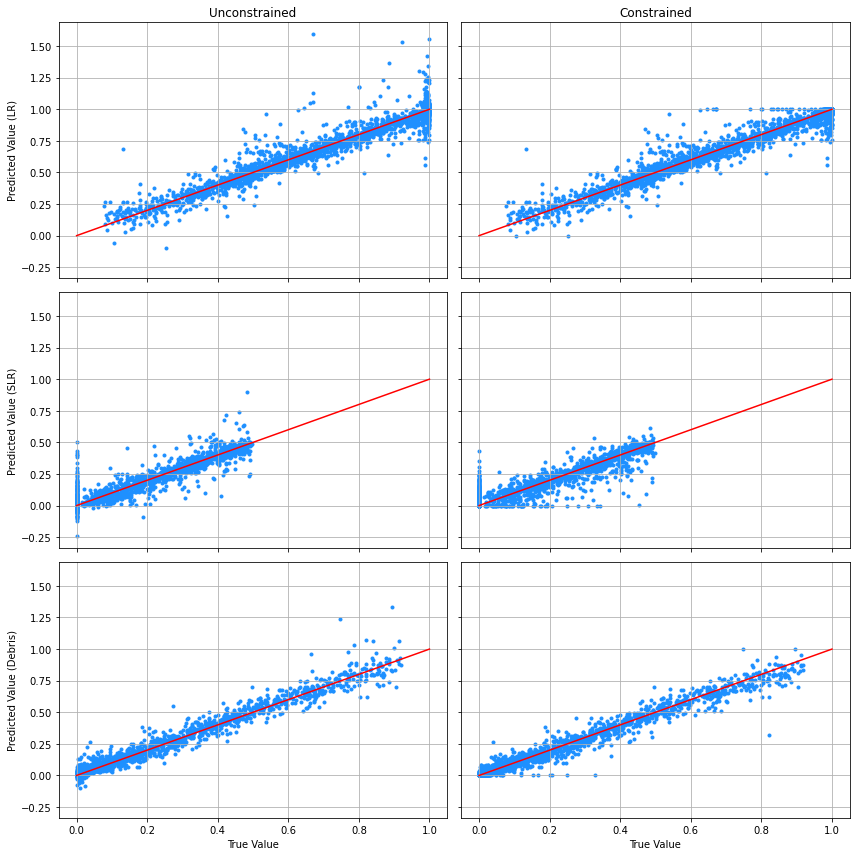

In [8]:
fig1, ax1 = plt.subplots(3, 2, figsize=(12,12), sharex=True, sharey=True)


# LR
y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, data.lr_true, data.lr_mass, data.lr_pred):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    
    
ax = ax1[0][0]

ax.set_title('Unconstrained')
ax.set_ylabel('Predicted Value (LR)')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[0][1]

ax.set_title('Constrained')


ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')



# SLR
y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, data.slr_true, data.slr_mass, data.slr_pred):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    
    
ax = ax1[1][0]

ax.set_ylabel('Predicted Value (SLR)')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[1][1]

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')



# Debris
y_test_norm = []
y_pred_norm = []
y_phys_norm = []

for m_tot, y_t, y_p, y_c in zip(x_test.mtotal, data.debris_true, data.debris_mass, data.debris_pred):
    y_test_norm.append( y_t / m_tot )
    y_pred_norm.append( y_p / m_tot )
    y_phys_norm.append( y_c / m_tot )
    
    
ax = ax1[2][0]

ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (Debris)')

ax.grid(True)

ax.scatter(y_test_norm, y_pred_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


ax = ax1[2][1]

ax.set_xlabel('True Value')

ax.grid(True)

ax.scatter(y_test_norm, y_phys_norm, marker='.', color='dodgerblue')

ax.plot([0,1], [0,1], color='red')


plt.tight_layout()